In [146]:
import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.layers import concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
from keras import backend as K
color = sns.color_palette()
import tensorflow as tf

%matplotlib inline

In [121]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

# Set the numpy seed
np.random.seed(111)

# Disable multi-threading in TensorFlow ops
session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

# Set the random seed in TensorFlow at graph level
tf.compat.v1.set_random_seed(111)

# Define a TensorFlow session with the above session configs
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)

# Set the session in Keras
tf.compat.v1.keras.backend.set_session(sess)

# Assuming `aug` is an instance of an augmentation class
# Make the augmentation sequence deterministic
aug.seed(111)


In [122]:
data_dir = Path('/Users/arminekarapetyan/Desktop/chest_xray')
# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'

In [58]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'
# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')
# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))
    # Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

,image,label
0,/Users/arminekarapetyan/Desktop/chest_xray/tra...,0
1,/Users/arminekarapetyan/Desktop/chest_xray/tra...,0
2,/Users/arminekarapetyan/Desktop/chest_xray/tra...,1
3,/Users/arminekarapetyan/Desktop/chest_xray/tra...,1
4,/Users/arminekarapetyan/Desktop/chest_xray/tra...,1


label
1    3875
0    1341
Name: count, dtype: int64


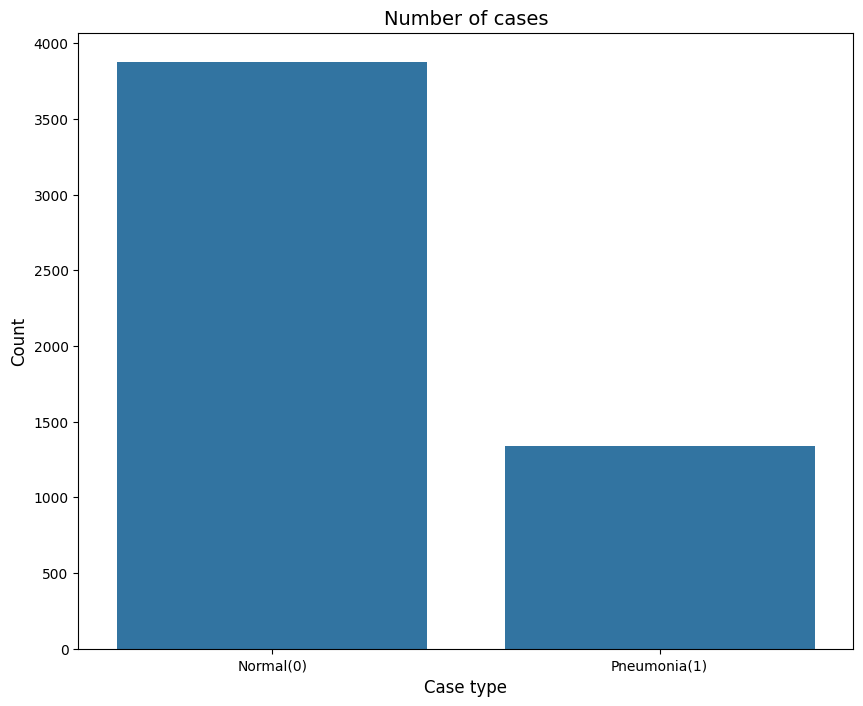

In [123]:
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

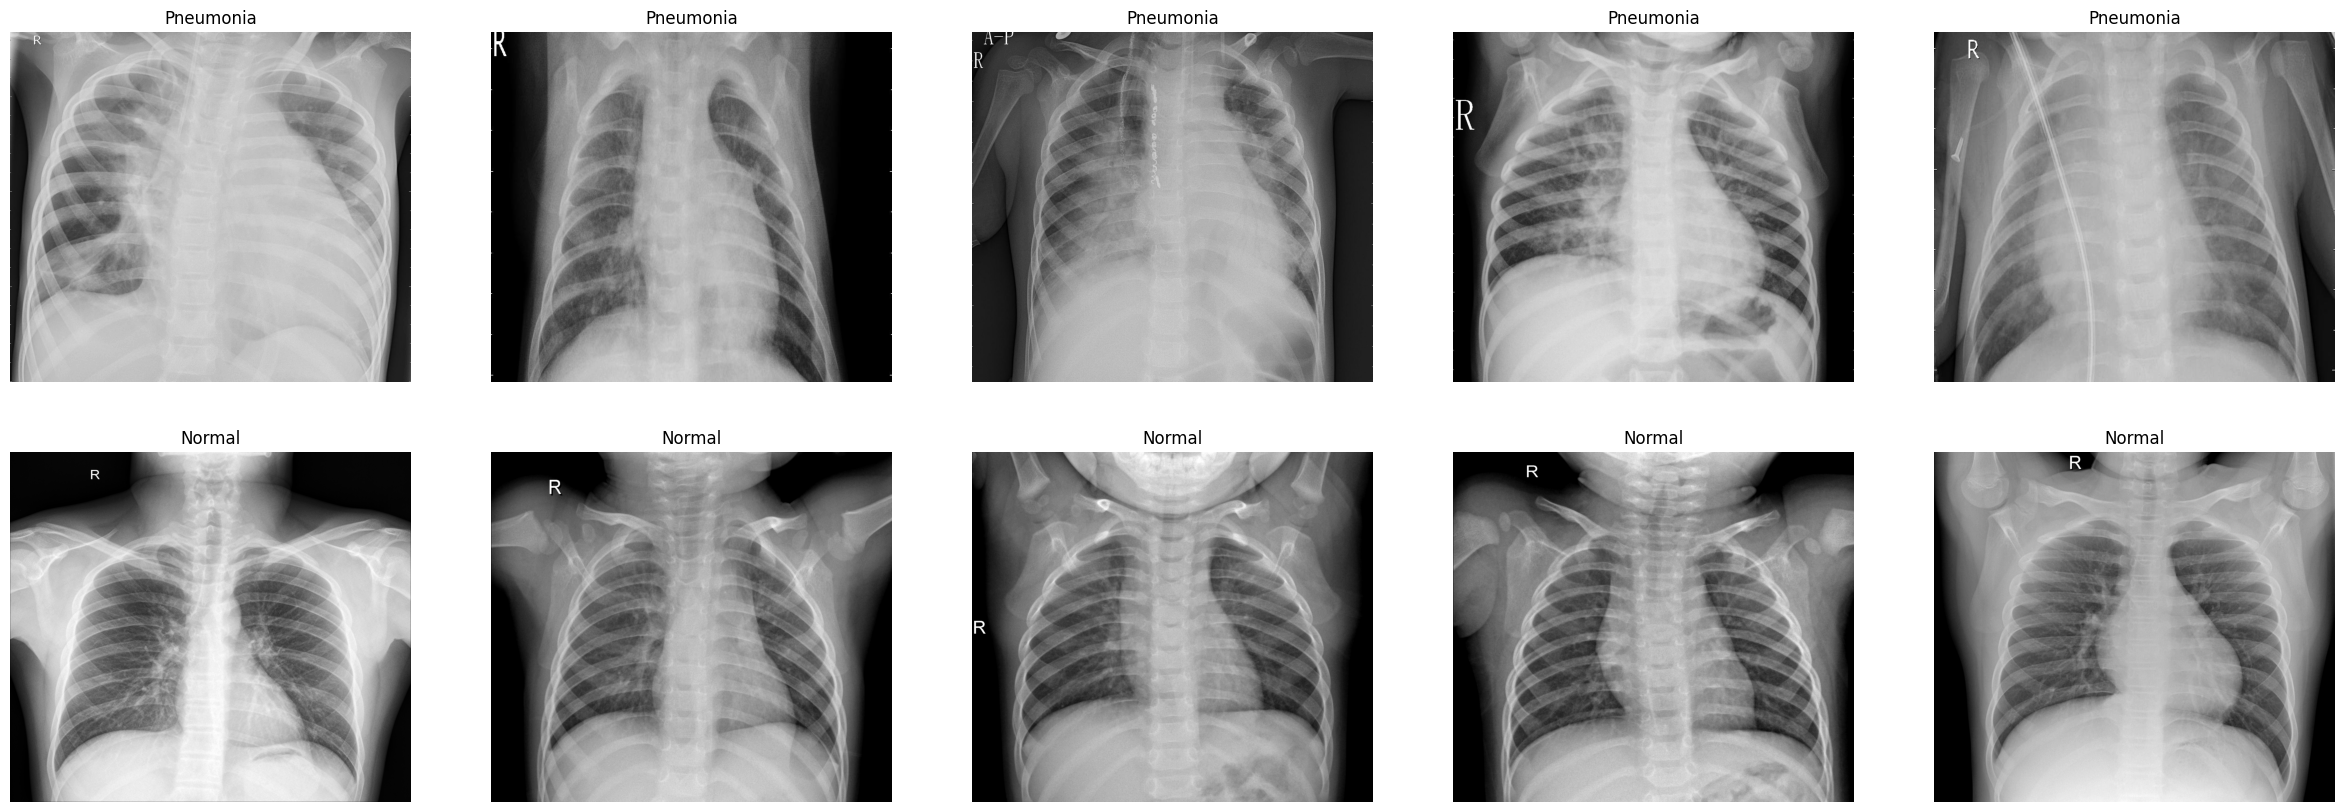

In [60]:
# Get few samples for both the classes
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

In [61]:
# Get the path to the sub-directories
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# List that are going to contain validation images data and the corresponding labels
valid_data = []
valid_labels = []
# Some images are in grayscale while majority of them contains 3 channels. So, if the image is grayscale, we will convert into a image with 3 channels.
# We will normalize the pixel values and resizing all the images to 224x224 

# Normal cases
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
# Pneumonia cases        
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
    
# Convert the list into numpy arrays
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

print("Total number of validation examples: ", valid_data.shape)
print("Total number of labels:", valid_labels.shape)

Total number of validation examples:  (16, 224, 224, 3)
Total number of labels: (16, 2)


In [124]:
# Augmentation sequence 
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=20), # roatation
    iaa.Multiply((1.2, 1.5))]) #random brightness

In [94]:
def data_gen(data, batch_size):
    # Get total number of samples in the data
    n = len(data)
    steps = n // batch_size

    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size, 2), dtype=np.float32)

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)

    # Initialize a counter
    i = 0
    while True:
        np.random.shuffle(indices)
        # Get the next batch
        count = 0
        next_batch = indices[i * batch_size : (i + 1) * batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]["image"]
            label = data.iloc[idx]["label"]

            # one hot encoding
            encoded_label = to_categorical(label, num_classes=2)
            # read the image and resize
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (224, 224))

            # check if it's grayscale
            if img.shape[2] == 1:
                img = np.dstack([img, img, img])

            # cv2 reads in BGR mode by default
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # normalize the image pixels
            orig_img = img.astype(np.float32) / 255.

            batch_data[count] = orig_img
            batch_labels[count] = encoded_label

            # generating more samples of the undersampled class
            if label == 0 and count < batch_size - 2:
                aug_img1 = seq.augment_image(img)
                aug_img2 = seq.augment_image(img)
                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
                aug_img1 = aug_img1.astype(np.float32) / 255.
                aug_img2 = aug_img2.astype(np.float32) / 255.

                batch_data[count + 1] = aug_img1
                batch_labels[count + 1] = encoded_label
                batch_data[count + 2] = aug_img2
                batch_labels[count + 2] = encoded_label
                count += 2

            else:
                count += 1

            if count == batch_size:
                break

        i += 1
        yield batch_data, batch_labels

        if i >= steps:
            i = 0

In [96]:
def build_model():
    input_img = Input(shape=(224,224,3), name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)
    
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(2, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

In [125]:
model =  build_model()
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ImageInput (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 Conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 Conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 Conv2_1 (SeparableConv2D)   (None, 112, 112, 128)     8896      
                                                                 
 Conv2_2 (SeparableConv2D)   (None, 112, 112, 128)     17664     
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0   

In [136]:
f = h5py.File('/Users/arminekarapetyan/Desktop/folder/vgg/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'r')
# Select the layers for which you want to set weight.

w,b = f['block1_conv1']['block1_conv1_W_1:0'], f['block1_conv1']['block1_conv1_b_1:0']
model.layers[1].set_weights = [w,b]

w,b = f['block1_conv2']['block1_conv2_W_1:0'], f['block1_conv2']['block1_conv2_b_1:0']
model.layers[2].set_weights = [w,b]

w,b = f['block2_conv1']['block2_conv1_W_1:0'], f['block2_conv1']['block2_conv1_b_1:0']
model.layers[4].set_weights = [w,b]

w,b = f['block2_conv2']['block2_conv2_W_1:0'], f['block2_conv2']['block2_conv2_b_1:0']
model.layers[5].set_weights = [w,b]

f.close()
model.summary()    

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ImageInput (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 Conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 Conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 Conv2_1 (SeparableConv2D)   (None, 112, 112, 128)     8896      
                                                                 
 Conv2_2 (SeparableConv2D)   (None, 112, 112, 128)     17664     
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0   

In [141]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import legacy as legacy_optimizers  # Import the legacy optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Model configuration
initial_learning_rate = 0.0001
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,  # Adjust as needed
    decay_rate=0.96,
    staircase=True
)

# Use the legacy Adam optimizer
opt = legacy_optimizers.Adam(learning_rate=lr_schedule)
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)

# Compile the model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=opt)

In [100]:
batch_size = 16
nb_epochs = 20

# Get a train data generator
train_data_gen = data_gen(data=train_data, batch_size=batch_size)

# Define the number of training steps
nb_train_steps = train_data.shape[0]//batch_size

print("Number of training and validation steps: {} and {}".format(nb_train_steps, len(valid_data)))

Number of training and validation steps: 326 and 16


In [157]:
train_data_gen

<generator object data_gen at 0x1398c0600>

In [101]:
train_data

,image,label
0,/Users/arminekarapetyan/Desktop/chest_xray/tra...,0
1,/Users/arminekarapetyan/Desktop/chest_xray/tra...,0
2,/Users/arminekarapetyan/Desktop/chest_xray/tra...,1
3,/Users/arminekarapetyan/Desktop/chest_xray/tra...,1
4,/Users/arminekarapetyan/Desktop/chest_xray/tra...,1
...,...,...
5211,/Users/arminekarapetyan/Desktop/chest_xray/tra...,0
5212,/Users/arminekarapetyan/Desktop/chest_xray/tra...,1
5213,/Users/arminekarapetyan/Desktop/chest_xray/tra...,1
5214,/Users/arminekarapetyan/Desktop/chest_xray/tra...,1


In [113]:
train_data['image'] = train_data['image'].astype(str)
train_data['label'] = train_data['label'].astype(str)



In [114]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator instance with your desired augmentations
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create a generator using the flow_from_dataframe method
generator = datagen.flow_from_dataframe(
    dataframe=train_data,  # your DataFrame
    directory=None,  # the directory where your images are located
    x_col="image",  # the column containing the image file paths
    y_col="label",  # the column containing the labels
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="categorical",  # "categorical" for one-hot encoded labels
    shuffle=True  # set to False if you want to maintain the order
)


Found 5216 validated image filenames belonging to 2 classes.


In [109]:
train_data.dtypes

image    object
label     int64
dtype: object

In [162]:
train_data.to_csv("train_data_desc.csv")

In [116]:
history = model.fit(
    generator,
    epochs=nb_epochs,
    steps_per_epoch=nb_train_steps,  # Set this to the number of batches you want per epoch
    validation_data=(valid_data, valid_labels),
    callbacks=[es, chkpt],
    class_weight={0: 1.0, 1: 0.4}
)

Epoch 1/20
326/326 [==============================] - 1954s 6s/step - loss: 0.1024 - accuracy: 0.9266 - val_loss: 9.0290 - val_accuracy: 0.5000
Epoch 2/20
326/326 [==============================] - 3070s 9s/step - loss: 0.0979 - accuracy: 0.9300 - val_loss: 3.0035 - val_accuracy: 0.5000
Epoch 3/20
326/326 [==============================] - 2115s 6s/step - loss: 0.0994 - accuracy: 0.9316 - val_loss: 6.8620 - val_accuracy: 0.5000
Epoch 4/20
326/326 [==============================] - 2479s 8s/step - loss: 0.1042 - accuracy: 0.9323 - val_loss: 0.6324 - val_accuracy: 0.6250
Epoch 5/20
326/326 [==============================] - 2353s 7s/step - loss: 0.0950 - accuracy: 0.9394 - val_loss: 1.0457 - val_accuracy: 0.5625
Epoch 6/20
326/326 [==============================] - 2245s 7s/step - loss: 0.0952 - accuracy: 0.9392 - val_loss: 1.2980 - val_accuracy: 0.6250
Epoch 7/20
326/326 [==============================] - 2111s 6s/step - loss: 0.0903 - accuracy: 0.9365 - val_loss: 0.7662 - val_accuracy:

In [117]:
model.save_weights('trained_weight.h5')

In [137]:
# Preparing test data
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

test_data = []
test_labels = []

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
    

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (624, 224, 224, 3)
Total number of labels: (624, 2)


In [142]:
model.load_weights("/Users/arminekarapetyan/Desktop/folder/trained_weights.h5")

# Evaluation on test dataset
test_loss, test_score = model.evaluate(test_data, test_labels, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)


39/39 [==============================] - 78s 2s/step - loss: 0.4146 - accuracy: 0.8365
Loss on test set:  0.4145556688308716
Accuracy on test set:  0.8365384340286255


In [143]:
# Get predictions
preds = model.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)


39/39 [==============================] - 84s 2s/step
(624,)
(624,)


<Figure size 640x480 with 0 Axes>

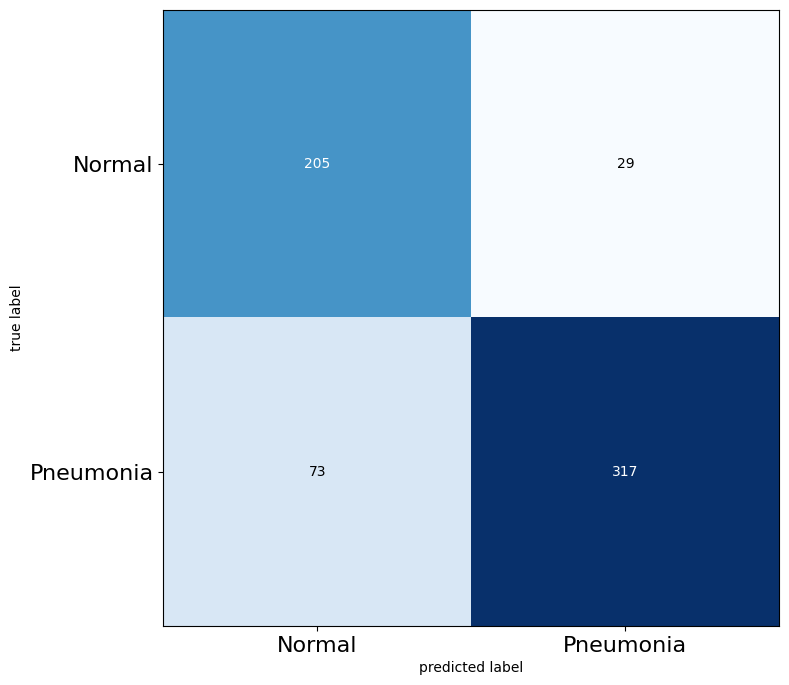

In [149]:
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)

plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [163]:
cm

array([[205,  29],
       [ 73, 317]])

In [150]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.81
Precision of the model is 0.92


In [151]:
f1 = 2 * (precision * recall) / (precision + recall)

print("F1 Score of the model is {:.2f}".format(f1))

F1 Score of the model is 0.86


20/20 [==============================] - 86s 4s/step


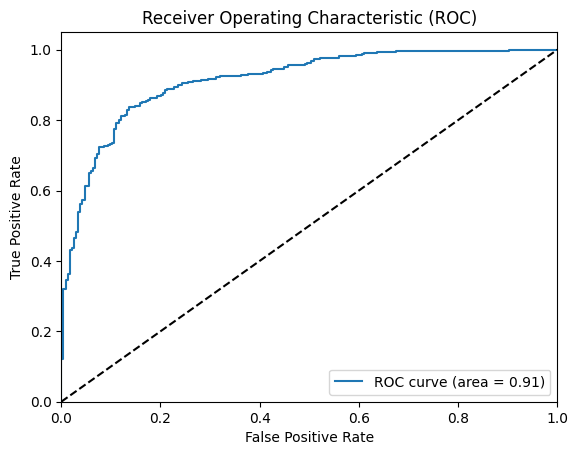

In [155]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming 'test_labels' are your true labels and 'model' is your trained model
# Replace 'test_data' with your actual test data
test_probabilities = model.predict(test_data)[:, 1]  # Get the probability of the positive class

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, test_probabilities)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
